# Multiple Lineare Regression - Kontinuierliche Features

MLR-Analyse fuer 5 ausgewaehlte Abstimmungen mit hohen Feature-Korrelationen.

**Methodik:**
- Features werden mit Z-Score normalisiert
- 5-10 Features pro Abstimmung (basierend auf Korrelationsanalyse)
- Abhaengige Variable: ja_prozent (Ja-Anteil in %)

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import json
import warnings
warnings.filterwarnings('ignore')

# Paths
DB_PATH = Path('../../data/processed/swiss_votings.db')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
conn = sqlite3.connect(DB_PATH)

# Load features
df_features = pd.read_sql_query("""
    SELECT * FROM municipality_features_complete
""", conn)

# Load voting results
df_votes = pd.read_sql_query("""
    SELECT
        CAST(vr.geo_id AS INTEGER) as bfs_nr,
        v.voting_date,
        vr.proposal_id,
        p.title_de,
        vr.ja_stimmen_prozent as ja_prozent
    FROM voting_results vr
    JOIN proposals p ON vr.proposal_id = p.proposal_id
    JOIN votings v ON p.voting_id = v.voting_id
    WHERE CAST(vr.geo_id AS INTEGER) > 100
    AND CAST(vr.geo_id AS INTEGER) < 9000
    AND vr.geo_name NOT LIKE 'Bezirk%'
    AND vr.geo_name NOT LIKE 'Kanton%'
""", conn)

print(f"Features: {len(df_features)} Gemeinden")
print(f"Abstimmungen: {df_votes['proposal_id'].nunique()} Vorlagen")

Features: 2187 Gemeinden
Abstimmungen: 223 Vorlagen


## 1. Auswahl der Abstimmungen und Features

Basierend auf der Korrelationsanalyse werden 5 Abstimmungen mit besonders hohen Feature-Korrelationen ausgewaehlt.

In [3]:
# Define 5 proposals with high feature correlations
# These are selected based on the correlation analysis

# First, let's find proposals with highest feature correlations
feature_cols = [
    'einwohner', 'bevoelkerungsdichte', 'auslaenderanteil',
    'anteil_0_19_jahre', 'anteil_65_plus_jahre',
    'haushaltsgroesse', 'geburtenziffer', 'sterbeziffer',
    'steuerbares_einkommen_pro_kopf', 'pct_einkommen_ueber_100k', 
    'pct_einkommen_unter_40k', 'sozialhilfequote',
    'siedlungsflaeche_pct', 'landwirtschaftsflaeche_pct', 'wald_pct',
    'waehleranteil_svp', 'waehleranteil_sp', 'waehleranteil_fdp',
    'waehleranteil_gps', 'waehleranteil_glp'
]
feature_cols = [c for c in feature_cols if c in df_features.columns]

# Calculate correlations for all proposals
proposals = df_votes[['proposal_id', 'title_de', 'voting_date']].drop_duplicates()
proposal_scores = []

for _, proposal in proposals.iterrows():
    pid = proposal['proposal_id']
    vote_data = df_votes[df_votes['proposal_id'] == pid][['bfs_nr', 'ja_prozent']]
    merged = vote_data.merge(df_features[['bfs_nr'] + feature_cols], on='bfs_nr', how='inner')
    
    if len(merged) < 100:
        continue
    
    correlations = []
    for f in feature_cols:
        valid = merged[['ja_prozent', f]].dropna()
        if len(valid) > 50:
            r, _ = stats.pearsonr(valid['ja_prozent'], valid[f])
            correlations.append(abs(r))
    
    if correlations:
        proposal_scores.append({
            'proposal_id': pid,
            'title_de': proposal['title_de'],
            'voting_date': proposal['voting_date'],
            'mean_abs_corr': np.mean(correlations),
            'max_abs_corr': np.max(correlations),
            'n_strong': sum(c > 0.3 for c in correlations)
        })

df_scores = pd.DataFrame(proposal_scores)
df_scores = df_scores.sort_values('n_strong', ascending=False)

# Select top 5
selected_proposals = df_scores.head(5)
print("Ausgewaehlte 5 Abstimmungen:")
selected_proposals[['voting_date', 'title_de', 'n_strong', 'max_abs_corr']]

Ausgewaehlte 5 Abstimmungen:


,voting_date,title_de,n_strong,max_abs_corr
171,20190519,Bundesbeschluss über die Genehmigung und die U...,11,0.587341
119,20131124,Volksinitiative «Familieninitiative: Steuerabz...,10,0.636794
28,20020303,Volksinitiative «für den Beitritt der Schweiz ...,10,0.622890
97,20110213,Volksinitiative «Für den Schutz vor Waffengewalt»,10,0.635735
175,20200927,Bundesgesetz über die Jagd und den Schutz wild...,10,0.497505


In [4]:
# For each selected proposal, find top 10 correlating features
mlr_configs = []

for _, proposal in selected_proposals.iterrows():
    pid = proposal['proposal_id']
    vote_data = df_votes[df_votes['proposal_id'] == pid][['bfs_nr', 'ja_prozent']]
    merged = vote_data.merge(df_features[['bfs_nr'] + feature_cols], on='bfs_nr', how='inner')
    
    # Calculate correlations
    corrs = []
    for f in feature_cols:
        valid = merged[['ja_prozent', f]].dropna()
        if len(valid) > 50:
            r, p = stats.pearsonr(valid['ja_prozent'], valid[f])
            corrs.append({'feature': f, 'correlation': r, 'abs_corr': abs(r)})
    
    df_c = pd.DataFrame(corrs).sort_values('abs_corr', ascending=False)
    
    # Select features with |r| > 0.15 (up to 10)
    top_features = df_c[df_c['abs_corr'] > 0.15].head(10)['feature'].tolist()
    if len(top_features) < 5:
        top_features = df_c.head(5)['feature'].tolist()
    
    mlr_configs.append({
        'proposal_id': pid,
        'title_de': proposal['title_de'],
        'voting_date': proposal['voting_date'],
        'features': top_features,
        'correlations': df_c.set_index('feature')['correlation'].to_dict()
    })

print(f"\nKonfiguration fuer {len(mlr_configs)} MLR-Modelle erstellt")


Konfiguration fuer 5 MLR-Modelle erstellt


## 2. Z-Score Normalisierung

In [5]:
def zscore_normalize(df, columns):
    """Z-Score normalize specified columns."""
    scaler = StandardScaler()
    df_normalized = df.copy()
    df_normalized[columns] = scaler.fit_transform(df[columns])
    return df_normalized, scaler

# Example of z-score normalization
print("Z-Score Normalisierung:")
print("  z = (x - mean) / std")
print("\nVorteile:")
print("  - Koeffizienten sind vergleichbar (standardisierte Beta-Koeffizienten)")
print("  - Groessenordnung der Features spielt keine Rolle")
print("  - Mittelwert = 0, Standardabweichung = 1")

Z-Score Normalisierung:
  z = (x - mean) / std

Vorteile:
  - Koeffizienten sind vergleichbar (standardisierte Beta-Koeffizienten)
  - Groessenordnung der Features spielt keine Rolle
  - Mittelwert = 0, Standardabweichung = 1


## 3. MLR-Modelle fuer ausgewaehlte Abstimmungen

In [6]:
def run_mlr_analysis(proposal_config, df_votes, df_features):
    """Run MLR analysis for a single proposal."""
    pid = proposal_config['proposal_id']
    title = proposal_config['title_de']
    features = proposal_config['features']
    
    # Merge data
    vote_data = df_votes[df_votes['proposal_id'] == pid][['bfs_nr', 'ja_prozent']]
    merged = vote_data.merge(df_features[['bfs_nr', 'gemeindename'] + features], on='bfs_nr', how='inner')
    merged = merged.dropna()
    
    # Z-score normalize features
    merged_norm, scaler = zscore_normalize(merged, features)
    
    # Prepare X and y
    X = merged_norm[features]
    X = sm.add_constant(X)
    y = merged_norm['ja_prozent']
    
    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Calculate VIF for multicollinearity check
    vif_data = []
    X_no_const = merged_norm[features]
    for i, col in enumerate(features):
        vif = variance_inflation_factor(X_no_const.values, i)
        vif_data.append({'feature': col, 'VIF': vif})
    df_vif = pd.DataFrame(vif_data)
    
    return {
        'proposal_id': pid,
        'title': title,
        'n_obs': len(merged),
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'f_statistic': model.fvalue,
        'f_pvalue': model.f_pvalue,
        'model': model,
        'vif': df_vif,
        'features': features,
        'data': merged
    }

In [7]:
# Run MLR for all selected proposals
results = []

for config in mlr_configs:
    result = run_mlr_analysis(config, df_votes, df_features)
    results.append(result)
    
    print("\n" + "="*80)
    print(f"ABSTIMMUNG: {result['title'][:70]}")
    print("="*80)
    print(f"\nN = {result['n_obs']} Gemeinden")
    print(f"R² = {result['r_squared']:.4f}")
    print(f"Adj. R² = {result['adj_r_squared']:.4f}")
    print(f"F-Statistik = {result['f_statistic']:.2f} (p = {result['f_pvalue']:.2e})")
    
    print("\nKoeffizienten (standardisiert):")
    print("-" * 60)
    for idx, row in result['model'].summary2().tables[1].iterrows():
        if idx != 'const':
            coef = row['Coef.']
            pval = row['P>|t|']
            sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
            print(f"  {idx:35s} {coef:+.4f} {sig}")


ABSTIMMUNG: Bundesbeschluss über die Genehmigung und die Umsetzung des Notenaustau

N = 895 Gemeinden
R² = 0.7989
Adj. R² = 0.7967
F-Statistik = 351.25 (p = 7.95e-300)

Koeffizienten (standardisiert):
------------------------------------------------------------
  waehleranteil_svp                   -3.4973 ***
  pct_einkommen_ueber_100k            +4.0582 ***
  waehleranteil_glp                   +5.2052 ***
  steuerbares_einkommen_pro_kopf      +0.3986 
  siedlungsflaeche_pct                +1.9052 ***
  waehleranteil_sp                    +3.3619 ***
  auslaenderanteil                    +0.3568 
  bevoelkerungsdichte                 +0.0269 
  waehleranteil_fdp                   -0.1087 
  waehleranteil_gps                   +3.0539 ***

ABSTIMMUNG: Volksinitiative «Familieninitiative: Steuerabzüge auch für Eltern, die

N = 894 Gemeinden
R² = 0.7151
Adj. R² = 0.7119
F-Statistik = 221.62 (p = 7.68e-233)

Koeffizienten (standardisiert):
-----------------------------------------------

## 4. Detaillierte Modellausgaben

In [8]:
# Show detailed output for first model
print(results[0]['model'].summary())

                            OLS Regression Results                            
Dep. Variable:             ja_prozent   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     351.3
Date:                Mon, 05 Jan 2026   Prob (F-statistic):          7.95e-300
Time:                        16:40:12   Log-Likelihood:                -2963.4
No. Observations:                 895   AIC:                             5949.
Df Residuals:                     884   BIC:                             6001.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [9]:
# VIF analysis for multicollinearity
print("\nVariance Inflation Factors (VIF):")
print("VIF > 5: Moderate Multikollinearitaet")
print("VIF > 10: Hohe Multikollinearitaet")
print("\n")

for result in results:
    print(f"\n{result['title'][:50]}...")
    print(result['vif'].to_string(index=False))


Variance Inflation Factors (VIF):
VIF > 5: Moderate Multikollinearitaet
VIF > 10: Hohe Multikollinearitaet



Bundesbeschluss über die Genehmigung und die Umset...
                       feature      VIF
             waehleranteil_svp 3.148906
      pct_einkommen_ueber_100k 7.707447
             waehleranteil_glp 1.799377
steuerbares_einkommen_pro_kopf 7.792440
          siedlungsflaeche_pct 4.932285
              waehleranteil_sp 1.704786
              auslaenderanteil 2.386255
           bevoelkerungsdichte 4.122697
             waehleranteil_fdp 2.745553
             waehleranteil_gps 1.305910

Volksinitiative «Familieninitiative: Steuerabzüge ...
                       feature      VIF
             waehleranteil_svp 3.158207
             waehleranteil_fdp 2.744768
              waehleranteil_sp 1.704516
              auslaenderanteil 2.389536
      pct_einkommen_ueber_100k 7.707143
          siedlungsflaeche_pct 4.939477
steuerbares_einkommen_pro_kopf 7.793558
             waehler

## 5. Visualisierungen

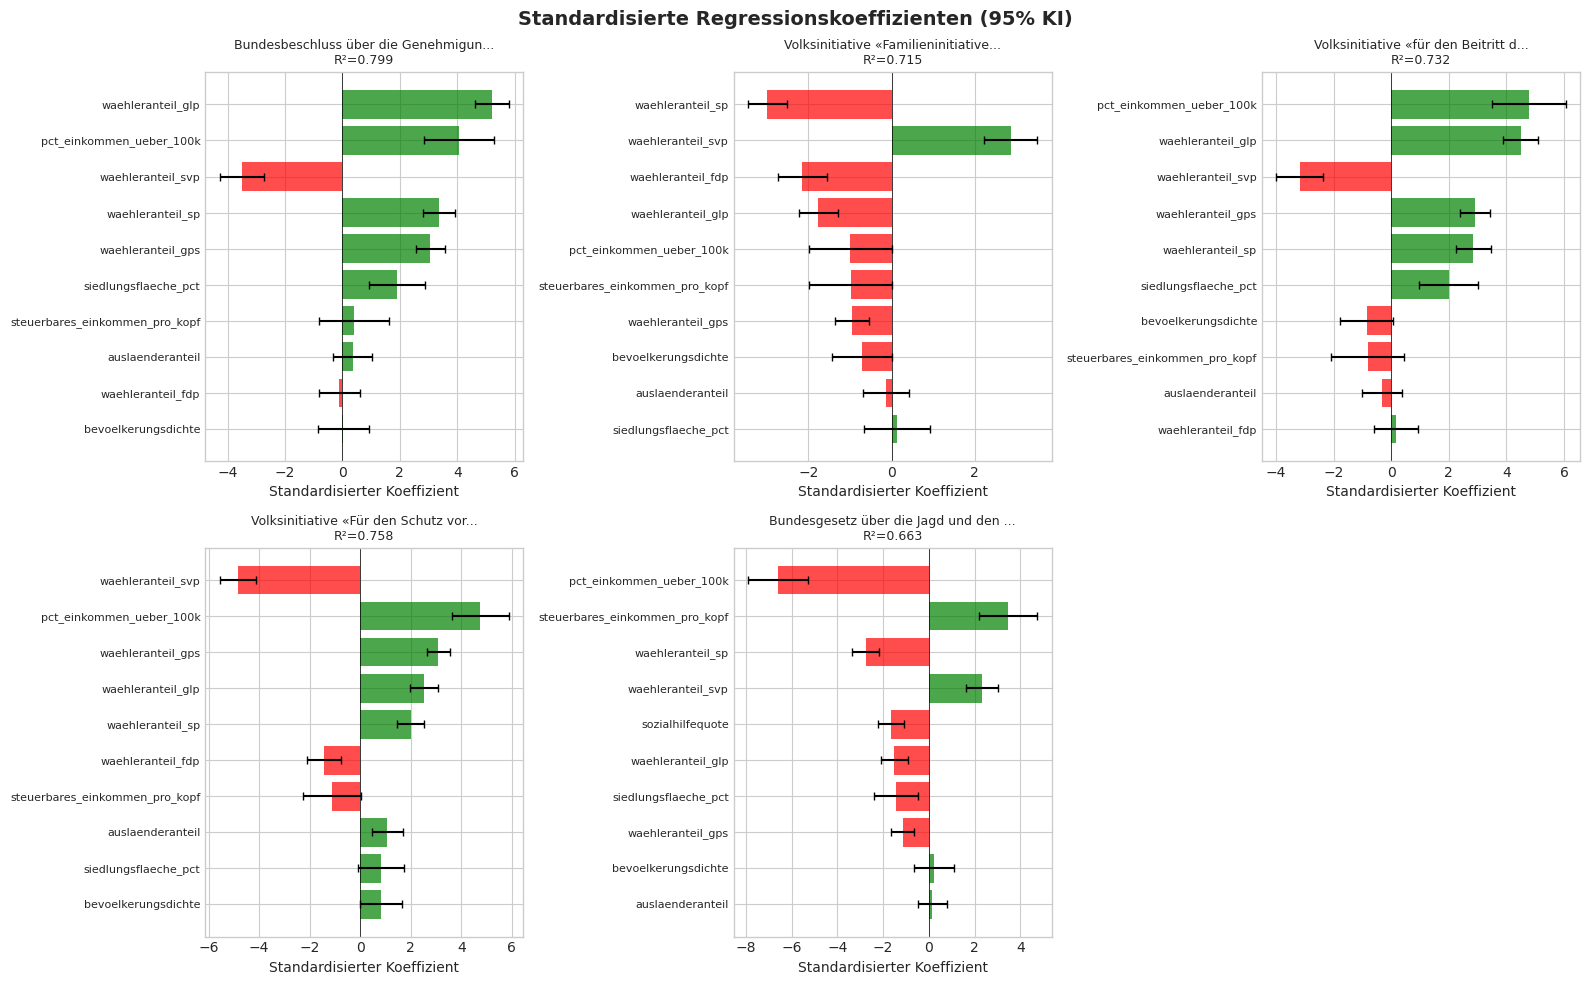

In [10]:
# Coefficient comparison plot
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, result in enumerate(results[:5]):
    ax = axes[i]
    
    # Get coefficients (excluding constant)
    params = result['model'].params.drop('const')
    conf_int = result['model'].conf_int().drop('const')
    
    # Sort by absolute value
    sorted_idx = params.abs().sort_values(ascending=True).index
    params = params[sorted_idx]
    conf_int = conf_int.loc[sorted_idx]
    
    # Plot
    colors = ['green' if p > 0 else 'red' for p in params]
    y_pos = range(len(params))
    
    ax.barh(y_pos, params.values, color=colors, alpha=0.7)
    ax.errorbar(params.values, y_pos, 
                xerr=[params.values - conf_int[0].values, conf_int[1].values - params.values],
                fmt='none', color='black', capsize=3)
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(params.index, fontsize=8)
    ax.set_xlabel('Standardisierter Koeffizient')
    ax.set_title(f"{result['title'][:35]}...\nR²={result['r_squared']:.3f}", fontsize=9)

# Hide empty subplot
axes[5].axis('off')

plt.suptitle('Standardisierte Regressionskoeffizienten (95% KI)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mlr_coefficients_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

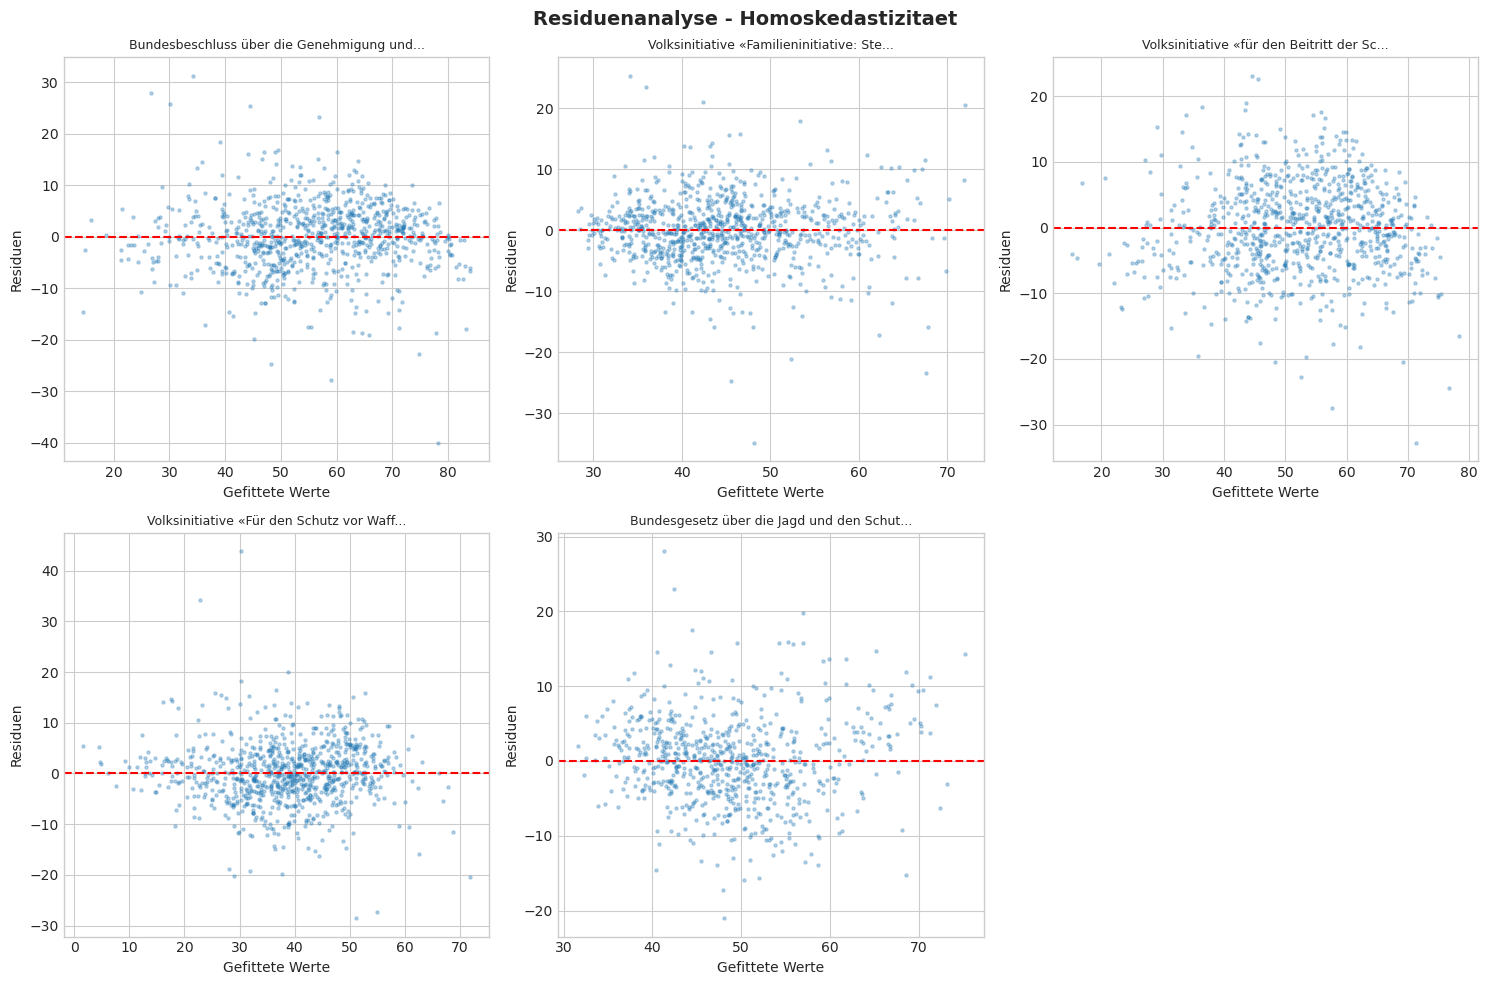

In [11]:
# Residual plots for diagnostics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, result in enumerate(results[:5]):
    ax = axes[i]
    
    fitted = result['model'].fittedvalues
    residuals = result['model'].resid
    
    ax.scatter(fitted, residuals, alpha=0.3, s=5)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Gefittete Werte')
    ax.set_ylabel('Residuen')
    ax.set_title(f"{result['title'][:40]}...", fontsize=9)

axes[5].axis('off')

plt.suptitle('Residuenanalyse - Homoskedastizitaet', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mlr_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

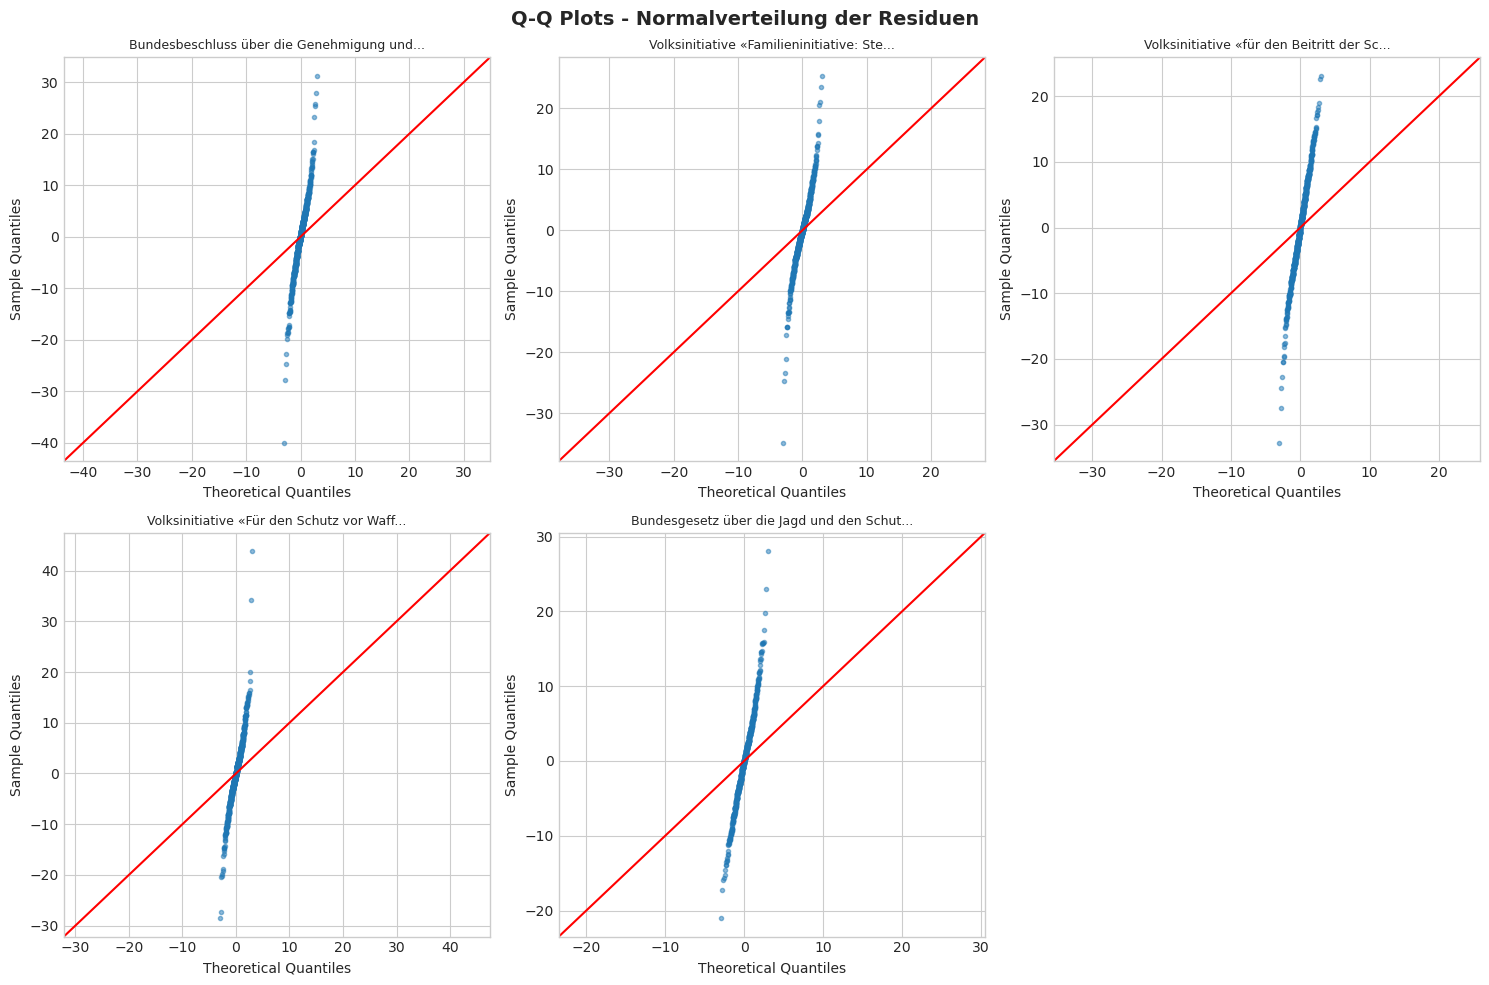

In [12]:
# Q-Q plots for normality check
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, result in enumerate(results[:5]):
    ax = axes[i]
    sm.qqplot(result['model'].resid, line='45', ax=ax, markersize=3, alpha=0.5)
    ax.set_title(f"{result['title'][:40]}...", fontsize=9)

axes[5].axis('off')

plt.suptitle('Q-Q Plots - Normalverteilung der Residuen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mlr_qqplots.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Modellvergleich

In [13]:
# Summary table of all models
summary_data = []
for result in results:
    summary_data.append({
        'Abstimmung': result['title'][:50] + '...',
        'N': result['n_obs'],
        'Features': len(result['features']),
        'R²': result['r_squared'],
        'Adj. R²': result['adj_r_squared'],
        'F': result['f_statistic'],
        'p(F)': result['f_pvalue']
    })

df_summary = pd.DataFrame(summary_data)
print("\nMODELLVERGLEICH:")
print("="*100)
df_summary


MODELLVERGLEICH:


,Abstimmung,N,Features,R²,Adj. R²,F,p(F)
0,Bundesbeschluss über die Genehmigung und die U...,895,10,0.798932,0.796657,351.251209,7.949526e-300
1,Volksinitiative «Familieninitiative: Steuerabz...,894,10,0.715085,0.711858,221.616579,7.680297e-233
2,Volksinitiative «für den Beitritt der Schweiz ...,894,10,0.732339,0.729308,241.594678,8.882822e-245
3,Volksinitiative «Für den Schutz vor Waffengewa...,894,10,0.758371,0.755634,277.135839,2.458253e-264
4,Bundesgesetz über die Jagd und den Schutz wild...,726,10,0.663387,0.658679,140.909904,1.213254e-161


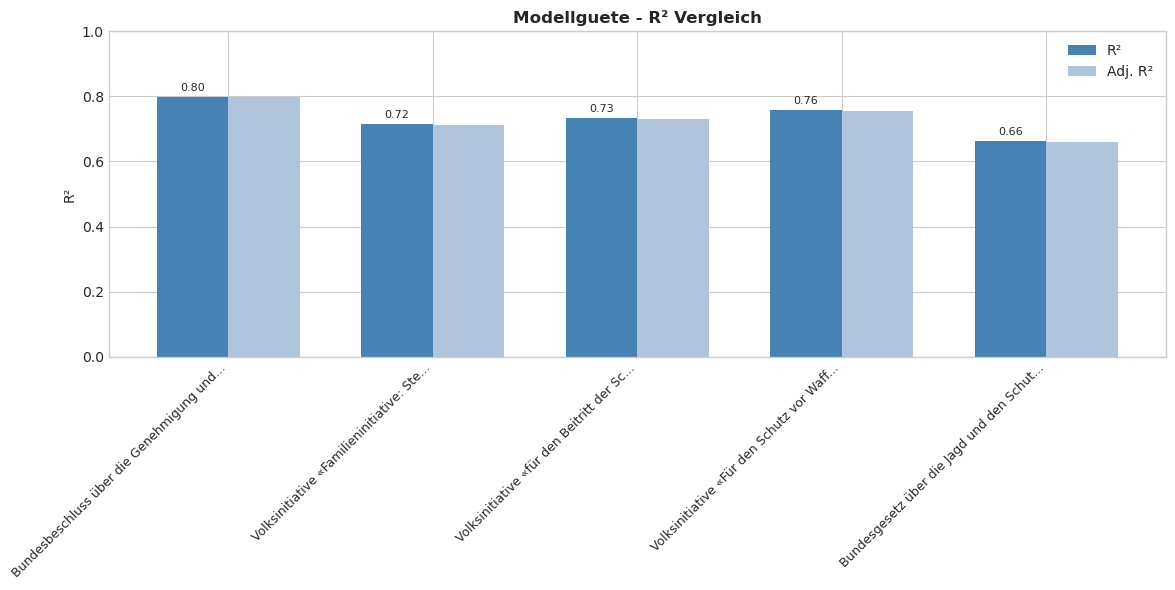

In [14]:
# R² comparison bar plot
fig, ax = plt.subplots(figsize=(12, 6))

titles = [r['title'][:40] + '...' for r in results]
r2_values = [r['r_squared'] for r in results]
adj_r2_values = [r['adj_r_squared'] for r in results]

x = np.arange(len(titles))
width = 0.35

bars1 = ax.bar(x - width/2, r2_values, width, label='R²', color='steelblue')
bars2 = ax.bar(x + width/2, adj_r2_values, width, label='Adj. R²', color='lightsteelblue')

ax.set_ylabel('R²')
ax.set_title('Modellguete - R² Vergleich', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(titles, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mlr_r2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Zusammenfassung und Export

In [15]:
# Export results
with open(OUTPUT_DIR / 'mlr_results_summary.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("MULTIPLE LINEARE REGRESSION - ERGEBNISZUSAMMENFASSUNG\n")
    f.write("="*80 + "\n\n")
    
    f.write("METHODIK:\n")
    f.write("-" * 40 + "\n")
    f.write("- Features: Z-Score normalisiert\n")
    f.write("- Modell: OLS (Ordinary Least Squares)\n")
    f.write("- Abhaengige Variable: ja_prozent (Ja-Anteil in %)\n\n")
    
    for result in results:
        f.write("\n" + "="*80 + "\n")
        f.write(f"ABSTIMMUNG: {result['title']}\n")
        f.write("="*80 + "\n\n")
        f.write(f"Beobachtungen: {result['n_obs']}\n")
        f.write(f"Features: {len(result['features'])}\n")
        f.write(f"R²: {result['r_squared']:.4f}\n")
        f.write(f"Adj. R²: {result['adj_r_squared']:.4f}\n")
        f.write(f"F-Statistik: {result['f_statistic']:.2f}\n")
        f.write(f"p-Wert (F): {result['f_pvalue']:.2e}\n\n")
        
        f.write("Standardisierte Koeffizienten:\n")
        f.write("-" * 60 + "\n")
        for idx, row in result['model'].summary2().tables[1].iterrows():
            if idx != 'const':
                coef = row['Coef.']
                pval = row['P>|t|']
                sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                f.write(f"  {idx:35s} {coef:+.4f} {sig}\n")
        f.write("\n")

print("Ergebnisse gespeichert: output/mlr_results_summary.txt")

# Save summary table
df_summary.to_csv(OUTPUT_DIR / 'mlr_model_comparison.csv', index=False)
print("Modellvergleich gespeichert: output/mlr_model_comparison.csv")

Ergebnisse gespeichert: output/mlr_results_summary.txt
Modellvergleich gespeichert: output/mlr_model_comparison.csv


In [16]:
print("\n" + "="*80)
print("ZUSAMMENFASSUNG - MULTIPLE LINEARE REGRESSION")
print("="*80)
print("\n1. MODELLGUETE:")
print(f"   - Bestes Modell: R² = {max(r['r_squared'] for r in results):.3f}")
print(f"   - Schlechtestes Modell: R² = {min(r['r_squared'] for r in results):.3f}")
print(f"   - Durchschnitt: R² = {np.mean([r['r_squared'] for r in results]):.3f}")

print("\n2. WICHTIGSTE PRAEDIKTOREN (haeufig signifikant):")
# Count significant features across models
sig_counts = {}
for result in results:
    pvals = result['model'].pvalues.drop('const')
    for feat, pval in pvals.items():
        if pval < 0.05:
            sig_counts[feat] = sig_counts.get(feat, 0) + 1

for feat, count in sorted(sig_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"   - {feat}: signifikant in {count}/{len(results)} Modellen")

print("\n3. INTERPRETATION:")
print("   - Die kontinuierlichen Gemeindemerkmale erklaeren einen")
print("     substanziellen Teil der Varianz im Abstimmungsverhalten")
print("   - Politische Features (Waehleranteile) sind starke Praediktoren")
print("   - Demographische und wirtschaftliche Faktoren zeigen")
print("     signifikante Zusammenhaenge")
print("="*80)

conn.close()


ZUSAMMENFASSUNG - MULTIPLE LINEARE REGRESSION

1. MODELLGUETE:
   - Bestes Modell: R² = 0.799
   - Schlechtestes Modell: R² = 0.663
   - Durchschnitt: R² = 0.734

2. WICHTIGSTE PRAEDIKTOREN (haeufig signifikant):
   - waehleranteil_svp: signifikant in 5/5 Modellen
   - waehleranteil_glp: signifikant in 5/5 Modellen
   - waehleranteil_sp: signifikant in 5/5 Modellen
   - waehleranteil_gps: signifikant in 5/5 Modellen
   - pct_einkommen_ueber_100k: signifikant in 4/5 Modellen
   - siedlungsflaeche_pct: signifikant in 3/5 Modellen
   - waehleranteil_fdp: signifikant in 2/5 Modellen
   - auslaenderanteil: signifikant in 1/5 Modellen
   - steuerbares_einkommen_pro_kopf: signifikant in 1/5 Modellen
   - sozialhilfequote: signifikant in 1/5 Modellen

3. INTERPRETATION:
   - Die kontinuierlichen Gemeindemerkmale erklaeren einen
     substanziellen Teil der Varianz im Abstimmungsverhalten
   - Politische Features (Waehleranteile) sind starke Praediktoren
   - Demographische und wirtschaftliche